# Problem statement

### Equation problem

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_\inf}{T_{b} - T_{\inf}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_\inf)}$


- $\epsilon_G=\epsilon(T_b-T_\inf)$


- $\epsilon_C=\beta(T_b-T_\inf)$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$

# Import libraries 

In [3]:
import torch
import imageio
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from torch.optim import SGD, LBFGS, Adam, RMSprop, SparseAdam
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Load Data

In [4]:
## Load dataset
relative_csv_path = "./../src/data/raw/Dataset.csv"
split_ratio = 0.2

# Load different temperatures samples 
fields = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
df_T = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
X_train, X_test = train_test_split(df_T, test_size = split_ratio)

# Load different G values 
fields = ['G']
df_G = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
Y_train, Y_test = train_test_split(df_G, test_size = split_ratio)

# Convert into numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
Y_train = Y_train.to_numpy()
Y = df_T.to_numpy()

# Print shapes
# print("X_test information:")
# print("the size of X_test is", X_test.size)
# print("the shape of X_test is", X_test.shape)

# print("X_train information:")
# print("the size of X_train is", X_train.size)
# print("the shape of X_train is", X_train.shape)

# print("Y_train information:")
# print("the size of Y_train is", Y_train.size)
# print("the shape of Y_train is", Y_train.shape)

# print("Y_test information:")
# print("the size of Y_test is", Y_test.size)
# print("the shape of Y_test is", Y_test.shape)

### Plot T(x) for different G values

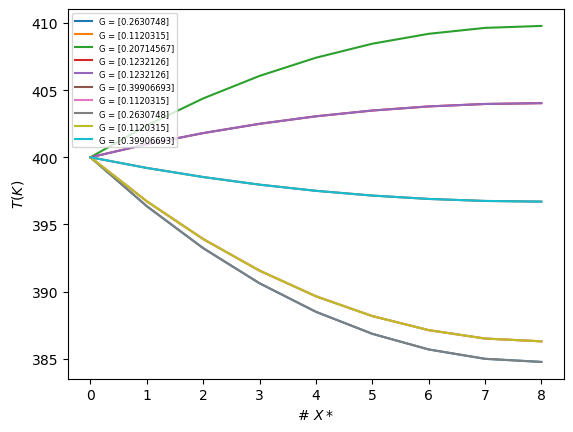

In [37]:
num_plots = 10
for i in range(num_plots):
  picked = np.random.randint(0, X_train.shape[1]) 
  label =  'G = {}'.format(Y_test[picked])
  plt.plot(X_train[picked,:],label=label)

plt.xlabel('# $X*$')
plt.ylabel('$T(K)$')
plt.legend(loc='upper left', prop={'size': 6})
plt.show()

## Compute $\theta$ as: `X_train`

In [39]:
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
X_train = np.multiply(np.add(X_train, [-T_inf]), [1/(T_b - T_inf)])
X_test = np.multiply(np.add(X_test, [-T_inf]), [1/(T_b - T_inf)])

### Normalization $\overline{\theta[i,j]} = 2\frac{\theta[i,j] \min(\theta[:,j]) }{\max(\theta[:,j]) - \min(\theta[:,j]) } - 1$ 

In [41]:
def normalize_ij(xi, xmax, xmin):
    "Function to normalize a value xi given xmax and xmin boundaries"
    return 2 * (xi - xmin) / (xmax - xmin) - 1

def normalize(X_array):
    """
    Normalize an array by columns computing the max and min of each column.
    
    Parameters:
    X_array(numpy array): Array to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_array.shape
    min_X_cols = [np.min(X_array[:,col_X]) for col_X in range(num_col_X)]
    max_X_cols = [np.max(X_array[:,col_X]) for col_X in range(num_col_X)]
    normalized_X_array = np.zeros_like(X_array)
    # Fill the copy vector
    for col in range(num_col_X): 
      for row in range(num_row_X):
        normalized_X_array[row,col] = normalize_ij(X_array[row,col], max_X_cols[col] , min_X_cols[col])
        
    return normalized_X_array

   ### Plot $\theta(x)$ for different G values

/tmp/ipykernel_6869/2189692938.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (xi - xmin) / (xmax - xmin) - 1


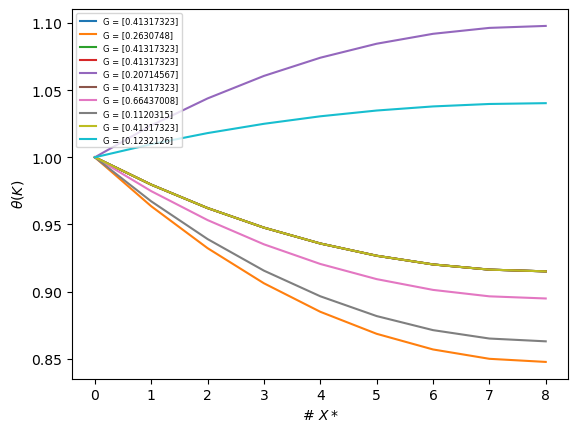

In [46]:
# normalize X_train
X_train_normalized = normalize(X_train)

num_plots = 10
for i in range(num_plots):
  picked = np.random.randint(0, X_train_normalized.shape[1]) 
  label =  'G = {}'.format(Y_test[picked])
  plt.plot(X_train[picked,:],label=label)

plt.xlabel('# $X*$')
plt.ylabel(r'$\theta (K)$')
plt.legend(loc='upper left', prop={'size': 6})
plt.show()

### Define a NN with customizable architecture


In [11]:
def create_NN(dim_input, dim_output, nun_nuerons_hidden_layers, num_hidden_layers):
    """
    Function to create a sequentual NN.

    Parameters:
       dim_input (int):                      Input dimension (number of features).
       dim_output (int):                     Output dimension (number of features).
       num_hidden_layers(int):               Number of hidden layers.
       nun_nuerons_hidden_layers (int):      Number of hidden layers.   
   """      
    # create an empty sequentail model
    Net = torch.nn.Sequential()

    # Add first layer 
    Net.add_module("input_layer", torch.nn.Linear(dim_input, nun_nuerons_hidden_layers))
     
    # Add hidden layers
    for nhidden_layer in range(num_hidden_layers):
        Net.add_module(
            "hidden_layer_num_{}".format(nhidden_layer + 1),
            torch.nn.Linear(nun_nuerons_hidden_layers, nun_nuerons_hidden_layers)
        )
        Net.add_module("hidden_activation_num_{}".format(nhidden_layer + 1 ), torch.nn.Tanh())

    # Add output layer
    Net.add_module("output_layer", torch.nn.Linear(nun_nuerons_hidden_layers, dim_output))
        
    return Net

## Train and test function: ` train_test_model `

In [70]:
def train_test_model(
    num_data_training, 
    nun_nuerons_hidden_layers, num_hidden_layers,
    num_epochs,
    X_train, Y_train, X_test, Y_test,
    generate_gif = False):
    """
    Function to build, test and traing the model.

    Parameters:
       num_data_trainging (int):        Number of samples.
       nun_nuerons_hidden_layers (int): Number of neurons for each hidden layer.
       num_hidden_layers (int):         Number of hidden layers.
       num_epochs (int):                Number of epochs to train the model.   
       X_train (ndarray):               Numpy array contaning the traning set inputs.   
       Y_train (ndarray):               Numpy array contaning the training set outputs.   
       X_test (ndarray):                Numpy array contaning the testing set inputs.   
       Y_test (ndarray):                Numpy array contaning the testing set outputs. 
       generate_gif (bool):             Boolean to generate a training .gif. 

   """        
    
    ###############################################
    ############# TRAINING STAGE ##################
    ###############################################
    
    # Pick the first num data trainig samples for X and Y
    X_train_reduced = X_train[:num_data_training,1:]
    num_col_Xr = X_train_reduced.shape[1]
    Y_train_reduced = Y_train[:num_data_training]
    num_col_Y = Y_train_reduced.shape[1]
    
    # Normalize X_train
    normalized_X_reduced_train = normalize(X_train_reduced)
    
    # Transofrm from numpy to torch into torch x_train and y_train 
    x_train = torch.from_numpy(normalized_X_reduced_train.reshape(-1,num_col_Xr)).float()
    y_train = torch.from_numpy(Y_train_reduced.reshape(-1,num_col_Y)).float()
    
    # Define model architecture 
    dim_input = x_train.shape[1]
    dim_output = num_col_Y
    Net = create_NN(dim_input, dim_output, nun_nuerons_hidden_layers, num_hidden_layers)
    
    # Watch x,y variables into torch
    x_train = Variable(x_train)
    y_train = Variable(y_train)
    
    # Training parameters
    loss_function = torch.nn.MSELoss()
    LearningRate = 1e-3
    adam_only_loss = np.zeros(num_epochs)

    # Define optimizer
    optimizer_adam = torch.optim.Adam(Net.parameters(), lr = LearningRate)
    # optimizer_lbfgs = LBFGS(Net.parameters(), history_size=5, max_iter=6)

    # Image
    if generate_gif:
        fig, ax = plt.subplots(figsize=(15,10))
        image_list = []

    # Train the model
    for epoch in range(num_epochs):
        y_pred = Net(x_train)
        loss = loss_function(y_pred, y_train)  # Notice the order: NN Pred first and then actual value
        optimizer_adam.zero_grad()       # Zero Out the gradient
        loss.backward()
        optimizer_adam.step()    
        #optimizer.step(closure)
        #loss = closure()
        adam_only_loss[epoch] = loss.detach().numpy()
        y_pred = Net(x_train)
        y_test = y_pred.detach().numpy()
        
        # Print gif for a 50 epochs step
        if epoch%50==0 and generate_gif:
            plt.cla()
            ax.set_xlabel('x', fontsize=32)
            ax.set_ylabel('y', fontsize=32)
            ax.set_xlim(-1, 1)
            ax.scatter(normalized_X_reduced_train[:,0], normalized_Y_reduced_train, color = "red", label="Training Data")
            ax.plot(normalized_X_reduced_train[:,0], y_test, 'k--', lw=2,  label="NN Apprximated")
            ax.text(-3, 6.0, 'Adam Optimizer: epoch = %d,' %epoch, fontdict={'size': 22, 'color':  'black'})
            ax.text(0.5, 6.0, 'Loss = %.6f' % loss,
                    fontdict={'size': 22, 'color':  'black'})
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.legend()

            fig.canvas.draw()      
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            image_list.append(image)

    if generate_gif:
        name = './Adam_func_{}.gif'.format(num_data_training)
        imageio.mimsave(name, image_list, fps=5)
    
    print(f"With num_data_training: {num_data_training} the final loss is: {loss:.5e}")

    
    ###############################################
    ############# TESTING STAGE ##################
    ###############################################
    # Normalize X_test
    X_test_reduced = X_test[:,1:]
    normalized_X_test = normalize(X_test_reduced)
    
    # Convert into torch x_test and y_test 
    x_test = torch.from_numpy(normalized_X_test.reshape(-1,num_col_Xr)).float()
    y_test = torch.from_numpy(Y_test.reshape(-1,num_col_Y)).float()

    # Compute y predict
    y_nn = Net(x_test)
    error_test = loss_function(y_nn, y_test).detach().numpy()  # Notice the order: NN Pred first and then actual value
        
    return adam_only_loss, error_test


With num_data_training: 10 the final loss is: 2.09972e-05
With num_data_training: 20 the final loss is: 1.57914e-02
With num_data_training: 30 the final loss is: 1.24775e-02
With num_data_training: 40 the final loss is: 2.95750e-02
With num_data_training: 50 the final loss is: 2.58288e-02
With num_data_training: 60 the final loss is: 3.94682e-02
With num_data_training: 70 the final loss is: 4.63879e-02
With num_data_training: 80 the final loss is: 4.86514e-02
With num_data_training: 90 the final loss is: 5.56773e-02
With num_data_training: 100 the final loss is: 4.05901e-02
With num_data_training: 110 the final loss is: 5.84939e-02
With num_data_training: 120 the final loss is: 5.36132e-02
With num_data_training: 130 the final loss is: 5.31317e-02
With num_data_training: 140 the final loss is: 4.86146e-02
With num_data_training: 150 the final loss is: 5.19459e-02
With num_data_training: 160 the final loss is: 5.34192e-02
With num_data_training: 170 the final loss is: 5.76460e-02
With n

In [ ]:

### Train the model for different number num_data_training 
# def train_model(num_data_training, num_of_neurons, num_epochs, X_train, Y_train):
nun_data_training = range(10,400,10)
num_epochs = 5000
num_of_neurons = 32
num_of_hidden_layers = 4

error_list = np.zeros(len(nun_data_training))
loss = np.zeros((len(nun_data_training),num_epochs))

for i,num_data in enumerate(nun_data_training):
    loss[i,:], error = train_test_model(num_data, num_of_neurons, num_of_hidden_layers, num_epochs, X_train, Y_train, X_test, Y_test)
    error_list[i] = error

## Print loss vs epochs

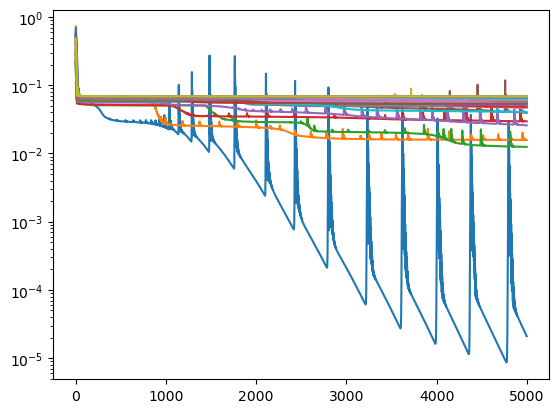

In [96]:
num_data_training_plot_case = 10
for i,num_data_training_plot_case in enumerate(nun_data_training):
    label = "Number of data used to train {}".format(num_data_training_plot_case) 
    plt.plot(range(num_epochs), loss[i,:], label="")
    plt.yscale('log')


# plt.legend(loc = 'best')

## Print error testing vs number of data training samples

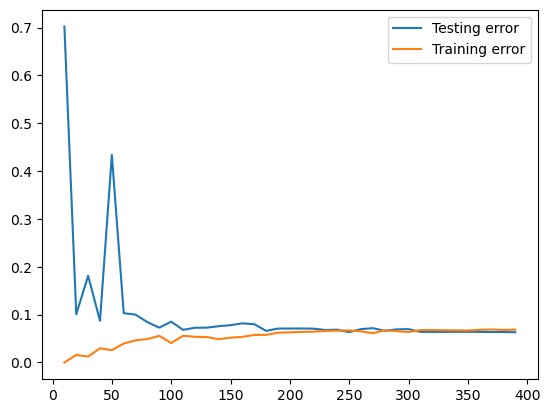

In [93]:
plt.plot(nun_data_training, error_list, label="Testing error")
# Add a comment
mean_loss = [ np.mean(loss[row,-11:-1])  for row in range(loss.shape[0])] 
plt.plot(nun_data_training, mean_loss, label="Training error")
plt.legend(loc = 'best')

In [ ]:
from matplotlib import pyplot

num_plot = 1
# pyplot.plot(loss[num_plot,:], color='blue', lw=2)
# pyplot.yscale('log')
# pyplot.show()

plt.plot(loss[num_plot,:],label="")
plt.title("Vanishing gradient??")
plt.show()
    

In [ ]:
plt.plot(X_train[picked,:],label=label)

plt.legend(loc = 'lower left')
# plt.title("Vanishing gradient")
plt.show()
    

In [ ]:
num_plots = 10
for i in range(num_plots):
  picked = np.random.randint(0, nun_data_training[-1]-1) 
  label =  'Sample number {}'.format(picked)
  plt.plot(X_train[picked,:],label=label)

plt.legend(loc = 'lower left')
# plt.title("Vanishing gradient")
plt.show()

### Ploting normalized $\theta(x)$ for a random G value

In [ ]:
num_plots = 1
for i in range(num_plots):
  picked = np.random.randint(0, nun_data_training[-1]) 
  label =  'Sample number {}'.format(picked)
  plt.plot(normalized_X_reduced_train[picked,:],label=label)
plt.legend(loc = 'lower left')
# plt.title("Vanishing gradient")
plt.show()



### Ploting normalized $\theta(x_i)$ for all G values $ \forall i \in [1:8]$


In [ ]:
for i in range(num_col_Xr):
    label =  'Point number {} of the fin'.format(i+1)
    plt.scatter(normalized_X_reduced_train[:,i],normalized_Y_reduced_train,label=label)
plt.legend(loc = 'lower left')
# plt.title("Vanishing gradient")
plt.show()
